# Quarterly quantitative program reports
This notebook lets me play around with quantitative analysis of Altru output. Currently set up to take two files, one with program data and another with attendee data.

**HOW TO USE THIS JUPYTER NOTEBOOK:** highlight the cell by clicking on it. You should see a green or blue box surround it. Then hold the Shift key and press Enter. You should see the highlight box move on to the next cell, and it will print or plot whatever the code says to do.
Try it here. Click on the gray text box below to highlight the cell, then hold Shift and press Enter.

In [26]:
print("Hello world!")

Hello world!


If it says **Hello world!** to you below the gray cell, it worked!

## Import statements, classes, and methods. 
Run these (Shift, Enter) then keep going. They shouldn't spit anything out at you. If they do, tell Abbie.

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme()
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
import ipywidgets as widgets
import traitlets
from IPython.display import display
from tkinter import Tk, filedialog

In [28]:
class SelectFilesButton(widgets.Button):
    """A file widget that leverages tkinter.filedialog."""

    def __init__(self):
        super(SelectFilesButton, self).__init__()
        # Add the selected_files trait
        self.add_traits(files=traitlets.traitlets.List())
        # Create the button.
        self.description = "Select Files"
        self.icon = "square-o"
        self.style.button_color = "orange"
        # Set on click behavior.
        self.on_click(self.select_files)

    @staticmethod
    def select_files(b):
        """Generate instance of tkinter.filedialog.

        Parameters
        ----------
        b : obj:
            An instance of ipywidgets.widgets.Button 
        """
        # Create Tk root
        root = Tk()
        # Hide the main window
        root.withdraw()
        # Raise the root to the top of all windows.
        root.call('wm', 'attributes', '.', '-topmost', True)
        # List of selected fileswill be set to b.value
        b.files = filedialog.askopenfilename(multiple=True)

        b.description = "Files Selected"
        b.icon = "check-square-o"
        b.style.button_color = "lightgreen"    

In [29]:
def clean_up_df(raw_df):
    """ 
    This method takes a dataframe with program information like Name, Location, Date, Time, Capacity, 
    and two rows for Attended, one with a number for 'Yes' and another with a number for 'No'
    """
    clean_df = pd.DataFrame(columns=('Name', 'Series', 'Location', 'Date', 'Time', 'Day', 
                                         'Capacity', 'Preregistered', 'Attended', 'Percentage'))
    clean_df['Name'] = raw_df['Name'].unique()
    for i in range(len(clean_df)):
        namemask = raw_df.where(raw_df['Name'] == clean_df['Name'][i])
        fvi = namemask.first_valid_index()
        clean_df.loc[i, 'Series'] = namemask['Series'][fvi]
        clean_df.loc[i, 'Location'] = namemask['Location'][fvi]
        clean_df.loc[i, 'Date'] = pd.to_datetime(namemask['Date'][fvi])
        clean_df.loc[i, 'Time'] = namemask['Time'][fvi]
        clean_df.loc[i, 'Capacity'] = namemask['Capacity'][fvi]
        yes_fvi = namemask.where(namemask['Attended'] == "Yes").first_valid_index()
        if yes_fvi == None:
            clean_df.loc[i,'Attended'] = 0
        else:
            clean_df.loc[i, 'Attended'] = namemask['Number'][yes_fvi]
        no_fvi = namemask.where(namemask['Attended'] == "No").first_valid_index()
        if no_fvi == None:
            clean_df.loc[i, 'Preregistered'] = clean_df['Attended'][i]
        else:
            clean_df.loc[i, 'Preregistered'] = clean_df['Attended'][i] + namemask['Number'][no_fvi]
                                                                                        
    clean_df['Percentage'] = clean_df['Attended'] / clean_df['Preregistered']
    clean_df.sort_values(by="Date", inplace=True)
    clean_df['Day'] = [j.strftime('%a') for j in clean_df['Date']]
    return clean_df

In [30]:
def convert_yesno_to_bool(yesno):
    """ This method converts 'yes' and 'no' in an Altru excel file to boolean values."""
    if yesno.casefold() == "yes".casefold():
        return True
    elif yesno.casefold() == "no".casefold():
        return False
    else:
        return np.nan

In [31]:
def get_ci90(df, groupbything, columnthing):
    """ This method gets the 90% confidence interval for errors on a distribution. 
    Need to use with errorbar=('ci', 90) in the plots!"""
    n = len(df)
    means = df.groupby(groupbything, observed=False)[columnthing].mean()
    print("Means:")
    print(means)
    stddevs = df.groupby(groupbything, observed=False)[columnthing].std()
    ci90 = 1.645 * (stddevs / np.sqrt(n))
    print("90% errors:")
    print(ci90)

## Run the cell below, then click the button to select your data file to load. 

The code expects an .xlsx data file made in Altru with the 'Program Query: Food Fight!' ad-hoc query. This file makes columns for the program name, program location, program date and time, participant capacity as specified in Altru, number of spaces still available, then two rows for each program: one with the number of pre-registrants who attended, and one with the number of pre-registrants who did not.

In [32]:
# button1 = SelectFilesButton()
# button1  # This will display the button in the context of Jupyter Notebook

Run this next cell to assign that file name to a variable and read in the excel file, then make a Pandas Dataframe called `programs` with the cleaned data. It will print basic information about the `programs` dataframe.

In [33]:
# program_xlsx_file = button1.files[0]
program_xlsx_file = "./fy25-q1_program_query.xlsx"
raw_program_data = pd.read_excel(program_xlsx_file, engine='openpyxl')
programs = clean_up_df(raw_program_data)
print(programs.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 3 to 2
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Name           5 non-null      object
 1   Series         5 non-null      object
 2   Location       5 non-null      object
 3   Date           5 non-null      object
 4   Time           5 non-null      object
 5   Day            5 non-null      object
 6   Capacity       5 non-null      object
 7   Preregistered  5 non-null      object
 8   Attended       5 non-null      object
 9   Percentage     5 non-null      object
dtypes: object(10)
memory usage: 440.0+ bytes
None


In [34]:
display(programs)

,Name,Series,Location,Date,Time,Day,Capacity,Preregistered,Attended,Percentage
3,A Midsummer Night's Disco,First Fridays FY 24-25,Beal Botanical Garden,2024-09-06 00:00:00,7:00 PM,Fri,1000.0,567.0,296.0,0.522046
0,Policies 101 with ASMSU,2024 Smithsonian National Youth Summit.,Communication Arts and Sciences Building,2024-09-17 00:00:00,5:00 PM,Tue,100.0,1.0,0.0,0.0
1,Navigating STEM and the Ballot: Empowered Voting,2024 Smithsonian National Youth Summit.,Communication Arts and Sciences Building,2024-09-18 00:00:00,6:00 PM,Wed,100.0,3.0,0.0,0.0
4,Artist Talk and Welcome,MSUFCU Arts Power Up: Lopez Lopez,Kresge Art Center,2024-09-19 00:00:00,5:10 PM,Thu,100.0,43.0,15.0,0.348837
2,Empower the Future: 2024 Youth Summit on Polit...,2024 Smithsonian National Youth Summit.,Communication Arts and Sciences Building,2024-09-20 00:00:00,10:00 AM,Fri,150.0,101.0,87.0,0.861386


In [35]:
## Shortening program series names
programs['Series'] = programs['Series'].replace("2024 Smithsonian National Youth Summit.", "SNYS")
programs['Series'] = programs['Series'].replace("First Fridays FY 24-25", "First Fridays")
programs['Series'] = programs['Series'].replace("MSUFCU Arts Power Up: Lopez Lopez", "Arts Power Up")
programs['Series'] = programs['Series'].fillna("Other")

nope_idx = programs['Name'].str.casefold().str.contains('cancelled|postponed'.casefold())
programs.loc[nope_idx,'Series'] = 'Other'
programs.loc[nope_idx, 'Percentage'] = np.nan

# type_cats = ['Workshop', 'Conversation', 'Performance', 'Other']
# programs['Type'] = pd.Categorical(programs['Type'], categories=type_cats, ordered=True)

## Shortening location names
programs['Location'] = programs['Location'].replace("Beal Botanical Garden", "Beal")
programs['Location'] = programs['Location'].replace("Communication Arts and Sciences Building", "WKAR")
programs['Location'] = programs['Location'].replace("Kresge Art Center", "Kresge")    
programs['Location'] = programs['Location'].replace("MSU Main Library", "MSU Library")  
display(programs)

,Name,Series,Location,Date,Time,Day,Capacity,Preregistered,Attended,Percentage
3,A Midsummer Night's Disco,First Fridays,Beal,2024-09-06 00:00:00,7:00 PM,Fri,1000.0,567.0,296.0,0.522046
0,Policies 101 with ASMSU,SNYS,WKAR,2024-09-17 00:00:00,5:00 PM,Tue,100.0,1.0,0.0,0.0
1,Navigating STEM and the Ballot: Empowered Voting,SNYS,WKAR,2024-09-18 00:00:00,6:00 PM,Wed,100.0,3.0,0.0,0.0
4,Artist Talk and Welcome,Arts Power Up,Kresge,2024-09-19 00:00:00,5:10 PM,Thu,100.0,43.0,15.0,0.348837
2,Empower the Future: 2024 Youth Summit on Polit...,SNYS,WKAR,2024-09-20 00:00:00,10:00 AM,Fri,150.0,101.0,87.0,0.861386


If you have cancelled or postponed programs (or other reasons why the attendance percentage would be Not a Number), filter those out of what's going to be plotted.

In [36]:
nan_idx = programs['Percentage'].isnull()
programs = programs.loc[~nan_idx]

If the program series is ongoing, filter out the ones that haven't happened yet.

In [37]:
future_idx = programs['Date'] > pd.Timestamp.today()
programs = programs.loc[~future_idx]

In [38]:
display(programs['Name'])

3                            A Midsummer Night's Disco
0                              Policies 101 with ASMSU
1     Navigating STEM and the Ballot: Empowered Voting
4                              Artist Talk and Welcome
2    Empower the Future: 2024 Youth Summit on Polit...
Name: Name, dtype: object

## Let's get some basic numbers!

How many people attended a program?

In [39]:
programs['Attended'].sum()

398.0

How many people pre-registered for a program?

In [40]:
programs['Preregistered'].sum()

715.0

Plot the attendance of programs as a function of time!

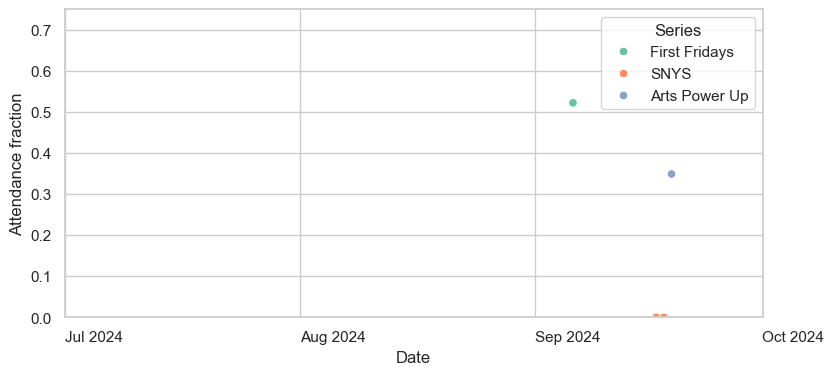

In [41]:
fig, ax = plt.subplots(figsize=(9,4))
fig = sns.scatterplot(data=programs, x='Date', y='Percentage', hue='Series', palette="Set2")
x_dates = pd.date_range(start='7/2024', end='10/2024', freq='MS', inclusive='both')
ax.set_xticks(x_dates, labels=x_dates.strftime('%b %Y'), horizontalalignment='left')
## TODO: mouseover to read name?!?
ax.set(ylim=(0, 0.75), ylabel="Attendance fraction")
fig.figure.savefig("program_attendance_timeline_scatter.png",bbox_inches='tight')
plt.show()

## Program type

In [42]:
get_ci90(programs.sort_values('Series'), 'Series', 'Percentage')

Means:
Series
Arts Power Up    0.348837
First Fridays    0.522046
SNYS             0.287129
Name: Percentage, dtype: object
90% errors:
Series
Arts Power Up         NaN
First Fridays         NaN
SNYS             0.365863
Name: Percentage, dtype: float64


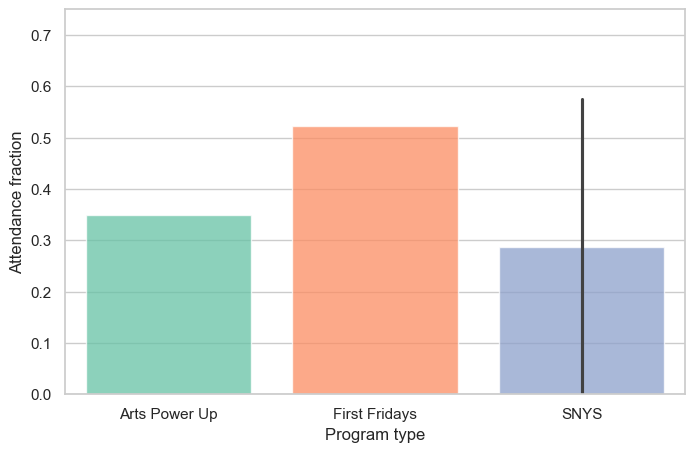

In [43]:
fig, ax = plt.subplots(figsize=(8,5))
fig = sns.barplot(data=programs.sort_values('Series'), x='Series', y='Percentage', palette='Set2', 
                  hue='Series', saturation=1, alpha=0.75, errorbar=('ci', 90))
ax.set(xlabel="Program type", ylabel="Attendance fraction", ylim=(0, 0.75))
fig.figure.savefig("program_series_bar.png", bbox_inches='tight')
plt.show()

## Program location

Rank the locations by number of programs held there.

In [44]:
loc_cats = programs['Location'].value_counts(ascending=False, dropna=True).index
programs['Location'] = pd.Categorical(programs['Location'], categories=loc_cats, ordered=True)

How was attendance of programs based on their location?

In [45]:
get_ci90(programs, 'Location', 'Percentage')

Means:
Location
WKAR      0.287129
Beal      0.522046
Kresge    0.348837
Name: Percentage, dtype: object
90% errors:
Location
WKAR      0.365863
Beal           NaN
Kresge         NaN
Name: Percentage, dtype: float64


Note: `NaN`, or `Not a Number`, is listed for the standard deviation on the last few because we only had one program at each of those locations.

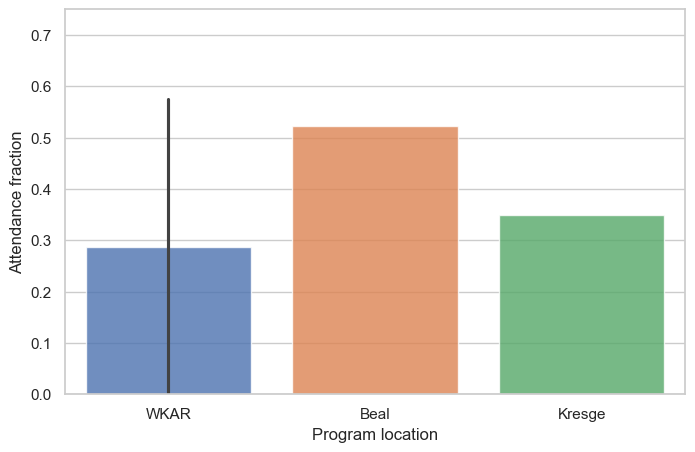

In [46]:
fig, ax = plt.subplots(figsize=(8,5))
sns.set_palette('deep')
fig = sns.barplot(data=programs, x='Location', y='Percentage', palette='deep', 
                  hue='Location', saturation=1, alpha=0.8, errorbar=('ci', 90))
ax.set(xlabel="Program location", ylabel="Attendance fraction", ylim=(0, 0.75))
fig.figure.savefig("program_location_bar.png", bbox_inches='tight')
plt.show()

## Time of day

In [47]:
get_ci90(programs.sort_values('Time'), 'Time', 'Percentage')

Means:
Time
10:00 AM    0.861386
5:00 PM          0.0
5:10 PM     0.348837
6:00 PM          0.0
7:00 PM     0.522046
Name: Percentage, dtype: object
90% errors:
Time
10:00 AM   NaN
5:00 PM    NaN
5:10 PM    NaN
6:00 PM    NaN
7:00 PM    NaN
Name: Percentage, dtype: float64


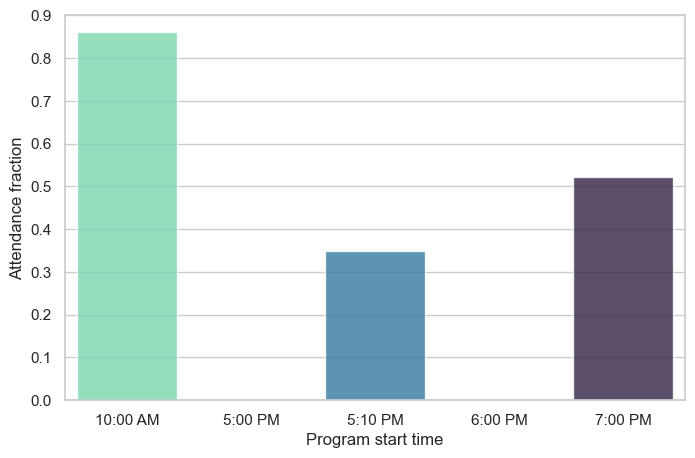

In [48]:
fig, ax = plt.subplots(figsize=(8,5))
fig = sns.barplot(data=programs.sort_values('Time'), x='Time', y='Percentage', palette='mako_r', 
                  hue='Time', saturation=1, alpha=0.8, errorbar=('ci', 90))
ax.set(xlabel="Program start time", ylabel="Attendance fraction", ylim=(0, 0.9))
fig.figure.savefig("program_time_bar.png", bbox_inches='tight')
plt.show()

## Day of week

Sort days of the week in calendar order, not alphabetical order.

In [49]:
day_cats = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
programs['Day'] = pd.Categorical(programs['Day'], categories=day_cats, ordered=True)

In [50]:
get_ci90(programs.sort_values('Day'), 'Day', 'Percentage')

Means:
Day
Mon         NaN
Tue         0.0
Wed         0.0
Thu    0.348837
Fri    0.691716
Sat         NaN
Sun         NaN
Name: Percentage, dtype: object
90% errors:
Day
Mon         NaN
Tue         NaN
Wed         NaN
Thu         NaN
Fri    0.176523
Sat         NaN
Sun         NaN
Name: Percentage, dtype: float64


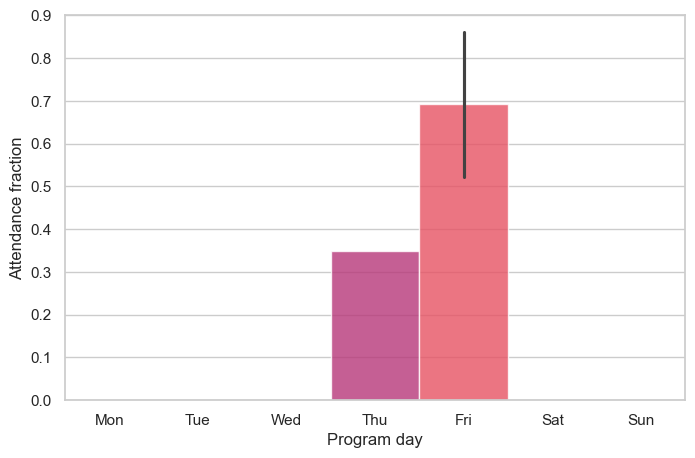

In [51]:
fig, ax = plt.subplots(figsize=(8,5))
fig = sns.barplot(data=programs.sort_values('Day'), x='Day', y='Percentage', palette='magma', 
                  hue='Day', saturation=1, alpha=0.8, width=1, dodge=False, errorbar=('ci', 90))
ax.set(xlabel="Program day", ylabel="Attendance fraction", ylim=(0, 0.9))
fig.figure.savefig("program_day_bar.png", bbox_inches='tight')
plt.show()

# Program attendees

Now we can get nitty-gritty. Let's load in the data file with all the registrants for each program.

**VERY IMPORTANT NOTE:** You need to open the excel file and double-check that the non-MSU affiliation says "Not MSU" instaed of "None". Otherwise, having no MSU affiliation gets merged with the people for whom we don't have that information. If needed, do find-replace IN EXCEL to switch "None" to "Not MSU".

In [52]:
# button2 = SelectFilesButton()
# button2  # This will display the button in the context of Jupyter Notebook

In [53]:
# reg_xlsx_file = button2.files[0]
reg_xlsx_file = "./fy25-q1_registrant_query.xlsx"

In [54]:
registrants = pd.read_excel(reg_xlsx_file, engine='openpyxl', converters={'Attended': convert_yesno_to_bool})
display(registrants.info())

# type_cats = ['Workshop', 'Conversation', 'Performance', 'Other']
# programs['Type'] = pd.Categorical(programs['Type'], categories=type_cats, ordered=True)

## Shortening location names
registrants['Program location'] = registrants['Program location'].replace("Beal Botanical Garden", "Beal")
registrants['Program location'] = registrants['Program location'].replace("Communication Arts and Sciences Building", "WKAR")
registrants['Program location'] = registrants['Program location'].replace("Kresge Art Center", "Kresge")    
#registrants['Program location'] = registrants['Program location'].replace("MSU Main Library", "MSU Library")  
registrants['MSU affiliation'] = registrants['MSU affiliation'].fillna("N/A")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Visitor name      717 non-null    object 
 1   Attended          717 non-null    bool   
 2   MSU affiliation   495 non-null    object 
 3   ZIP code          373 non-null    object 
 4   Program name      716 non-null    object 
 5   Program location  717 non-null    object 
 6   Host name         481 non-null    object 
 7   Number of guests  717 non-null    int64  
 8   Notes             0 non-null      float64
 9   QUERYRECID        717 non-null    object 
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 51.2+ KB


None

In [55]:
series_cats = programs['Series'].unique()
registrants['Program series'] = pd.Categorical(np.empty(len(registrants)), categories=series_cats, ordered=True)
print(series_cats)
print(registrants['Program name'].unique())

['First Fridays' 'SNYS' 'Arts Power Up']
["A Midsummer Night's Disco" 'Artist Talk and Welcome'
 'Empower the Future: 2024 Youth Summit on Politics and Activism'
 'CANCELLED: Media Literacy & Politics: Navigating News in the Digital Age with WKAR'
 nan 'Policies 101 with ASMSU'
 'Navigating STEM and the Ballot: Empowered Voting']


In [56]:
snys_progs = programs['Name'][programs['Series'] == 'SNYS'].tolist()
ff_progs = programs['Name'][programs['Series'] == 'First Fridays'].tolist()
apu_progs = programs['Name'][programs['Series'] == 'Arts Power Up'].tolist()

for i in range(len(registrants)):
    if registrants.loc[i, 'Program name'] in (snys_progs):
        registrants.loc[i, 'Program series'] = 'SNYS'
    elif registrants.loc[i, 'Program name'] in ff_progs:
        registrants.loc[i, 'Program series'] = 'First Fridays'
    elif registrants.loc[i, 'Program name'] in apu_progs:
        registrants.loc[i, 'Program series'] = 'Arts Power Up'

We can assign a preferred order to display the MSU affiliations.

In [57]:
affil_cats = ['Student', 'Faculty/Staff', 'Alum', 'Parent/Family', 'Not MSU', 'N/A']
registrants['MSU affiliation'] = pd.Categorical(registrants['MSU affiliation'], categories=affil_cats, ordered=True)

Only keep the records of who attended a program that we kept in the `programs` dataframe, done by program name, since we did some filtering previously.

In [58]:
registrants = registrants[registrants['Program name'].isin(programs['Name'].unique().tolist())]
print(registrants['Program location'].unique())

['Beal' 'Kresge' 'WKAR']


Note: attendance numbers here might be different than above, since people could register guests, but you'd need to sum number of guests where attended=True plus sum attended.

In [59]:
print(len(registrants))
print(sum(registrants['Attended']))

715
398


Remove myself, since I sign up for every program to test the links and emails.

In [60]:
notme_idx = ["Abbie Stevens".casefold() not in item.casefold() for item in registrants['Visitor name']]
registrants = registrants.loc[notme_idx]

Remove CoLab Studio, since that's our generic host for walk-ins. (I tried just removing its affiliation, but that threw errors down below with the `hosts` dataframe).

In [61]:
colab_idx = ["CoLab Studio".casefold() in item.casefold() for item in registrants['Visitor name']]
registrants.loc[colab_idx, 'MSU affiliation'] = np.nan

2-dimensional histograms are kinda weird but fun. We can look at total pre-registration as a function of MSU affiliation **and** program location!

/var/folders/2b/bxdw1yzn5_vb2kd7bdhn0z3c0000gr/T/ipykernel_27333/1026409643.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels(fig.get_xticklabels(), rotation=345)


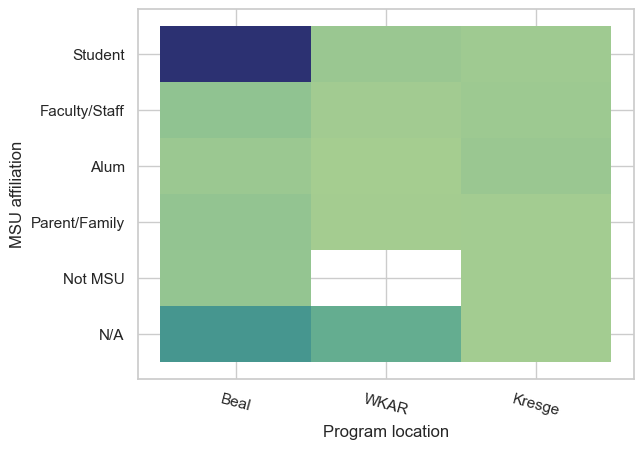

In [62]:
fig = sns.histplot(registrants, x='Program location', y='MSU affiliation', cmap='crest')
fig.set_xticklabels(fig.get_xticklabels(), rotation=345)
plt.show()

We can see that programs at Beal had a relatively higher number of `Not MSU` affiliations than programs at other locations. The program at RCAH was early in the semester, so lots of pre-registration happened before we realized we weren't collecting MSU affiliation data, hence the high number of `N/A` registrants.

/var/folders/2b/bxdw1yzn5_vb2kd7bdhn0z3c0000gr/T/ipykernel_27333/2423708650.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_yticklabels(fig.get_yticklabels(), rotation=60, va='center')


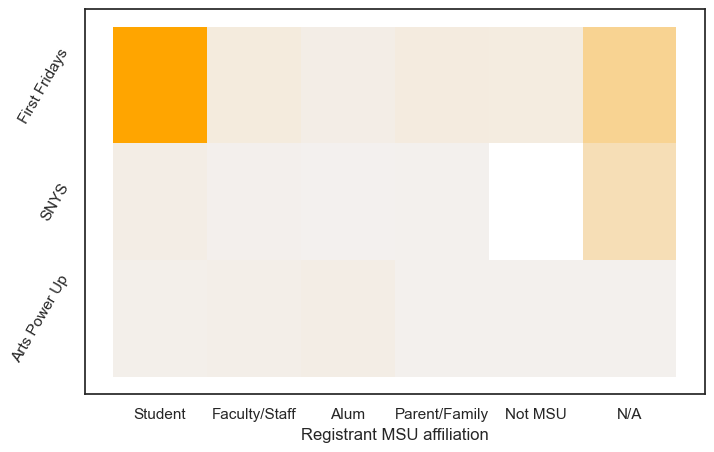

In [63]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(8,5))
fig = sns.histplot(registrants, x='MSU affiliation', y='Program series', cmap='light:orange')
ax.set(xlabel="Registrant MSU affiliation", ylabel="")
fig.set_yticklabels(fig.get_yticklabels(), rotation=60, va='center')
#fig.figure.savefig("2D_reg_affil_type.png", bbox_inches='tight')
plt.show()

/var/folders/2b/bxdw1yzn5_vb2kd7bdhn0z3c0000gr/T/ipykernel_27333/2835369709.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_yticklabels(fig.get_yticklabels(), rotation=60, va='center')


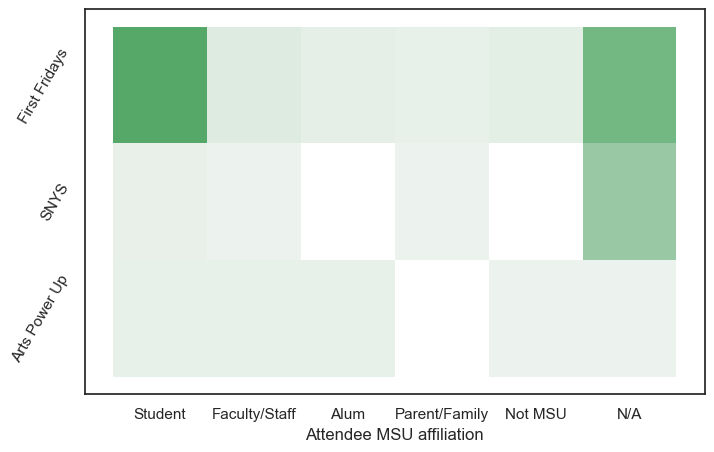

In [64]:
fig, ax = plt.subplots(figsize=(8,5))
fig = sns.histplot(registrants.iloc[np.where(registrants['Attended'])], 
                   x='MSU affiliation', y='Program series', cmap='light:g')
ax.set(xlabel="Attendee MSU affiliation", ylabel="")
fig.set_yticklabels(fig.get_yticklabels(), rotation=60, va='center')
#fig.figure.savefig("2D_attend_affil_type.png", bbox_inches='tight')
plt.show()

In [65]:
sns.set_style('whitegrid')

## MSU affiliation

Let's clean the registrant data and make a new dataframe where each individal is listed once, and we sum the number of pre-registrations and attendances they had.

In [68]:
reg_by_name = pd.DataFrame(columns=('Visitor name', 'Attended', 'Preregistered', 'Percentage', 'Host name', 'MSU affiliation'))
reg_by_name['Visitor name'] = registrants['Visitor name'].unique()
nas_with_other = 0
for i in range(len(reg_by_name['Visitor name'])):
    appearances = registrants['Visitor name'].values == reg_by_name.loc[i, 'Visitor name']
#    host_times = sum(registrants['Host name'].values == reg_by_name.loc[i, 'Visitor name'])
#    guests = sum(registrants.loc[appearances, 'Number of guests'])
    reg_by_name.loc[i, 'Preregistered'] = sum(appearances) # sum of times it appears in the whole registrants list, plus guests
    reg_by_name.loc[i, 'Attended'] = sum(registrants.loc[appearances, 'Attended'])#sum of attended where name == visitors name
  #  reg_by_name.loc[i, 'Host name'] = [registrants.loc[appearances,'Host name'].tolist()]
    affil = registrants.loc[appearances, 'MSU affiliation'].unique()
    if len(affil) > 1 and "N/A" in affil:
        reg_by_name.loc[i, 'MSU affiliation'] = np.delete(affil, np.where(affil == 'N/A'))[0]
        nas_with_other += 1
    else:
        reg_by_name.loc[i, 'MSU affiliation'] = affil[0]
reg_by_name['Percentage'] = reg_by_name['Attended'] / reg_by_name['Preregistered']
reg_by_name['MSU affiliation'] = pd.Categorical(reg_by_name['MSU affiliation'], categories=affil_cats, ordered=True)

In [69]:
#display(reg_by_name)

# TODO: write this up so it prints prettily, so i can copy/paste into the Word doc report.

In [70]:
print(sum(reg_by_name['Preregistered']))
print(sum(reg_by_name['Attended']))

714
397


In [71]:
print("Unique registrants: %d" % len(reg_by_name))
print("Unique attendees: %d" % len(np.where(reg_by_name['Attended'] > 0)[0]))

Unique registrants: 591
Unique attendees: 287


In [72]:
print("\tSUM OF PRE-REGISTRATIONS:")
display(reg_by_name.groupby('MSU affiliation', observed=False)['Preregistered'].sum())

	SUM OF PRE-REGISTRATIONS:


MSU affiliation
Student          370
Faculty/Staff     42
Alum              28
Parent/Family     27
Not MSU           24
N/A              222
Name: Preregistered, dtype: object

In [73]:
print("\tSUM OF ATTENDANCES:")
display(reg_by_name.groupby('MSU affiliation', observed=False)['Attended'].sum())

	SUM OF ATTENDANCES:


MSU affiliation
Student          154
Faculty/Staff     20
Alum              11
Parent/Family      5
Not MSU           10
N/A              197
Name: Attended, dtype: object

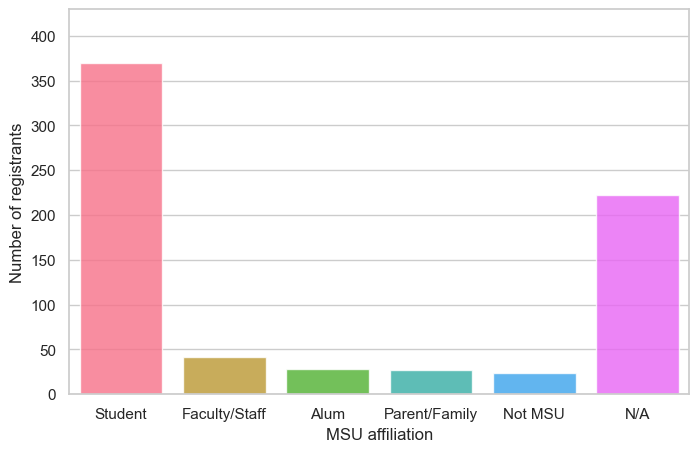

In [74]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(8,5))
sns.set_palette("husl")
fig = sns.barplot(data=reg_by_name, x='MSU affiliation', y='Preregistered', palette='husl', 
                  hue='MSU affiliation', estimator=sum, saturation=1, alpha=0.8, err_kws={'linewidth': 0})
ax.set(xlabel="MSU affiliation", ylabel="Number of registrants")
ax.get_legend().remove()
fig.figure.savefig("pre-reg_affil_bar.png", bbox_inches='tight')
plt.show()

In [75]:
get_ci90(reg_by_name, 'MSU affiliation', 'Percentage')

Means:
MSU affiliation
Student          0.415531
Faculty/Staff    0.463964
Alum             0.384615
Parent/Family    0.185185
Not MSU          0.416667
N/A              0.808869
Name: Percentage, dtype: object
90% errors:
MSU affiliation
Student          0.033252
Faculty/Staff    0.033321
Alum             0.033572
Parent/Family    0.026786
Not MSU          0.034077
N/A              0.025946
Name: Percentage, dtype: float64


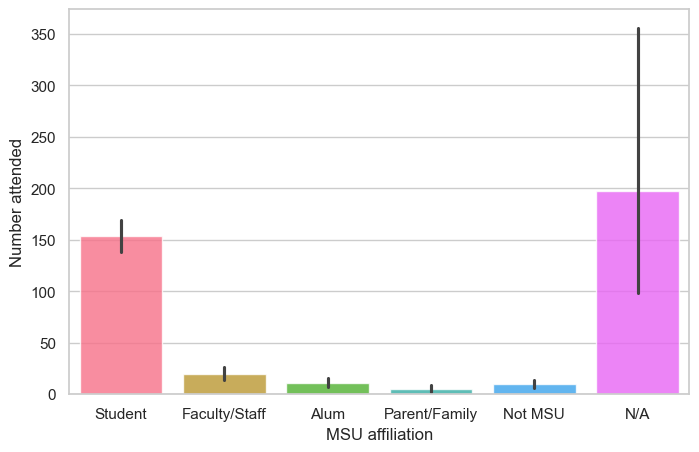

In [76]:
fig, ax = plt.subplots(figsize=(8,5))
fig = sns.barplot(data=reg_by_name, x='MSU affiliation', y='Attended', palette='husl', 
                  hue='MSU affiliation', estimator='sum', saturation=1, alpha=0.8, errorbar=('ci', 90))
ax.set(xlabel="MSU affiliation", ylabel="Number attended")
ax.get_legend().remove()
fig.figure.savefig("attend_affil_bar.png", bbox_inches='tight')
plt.show()

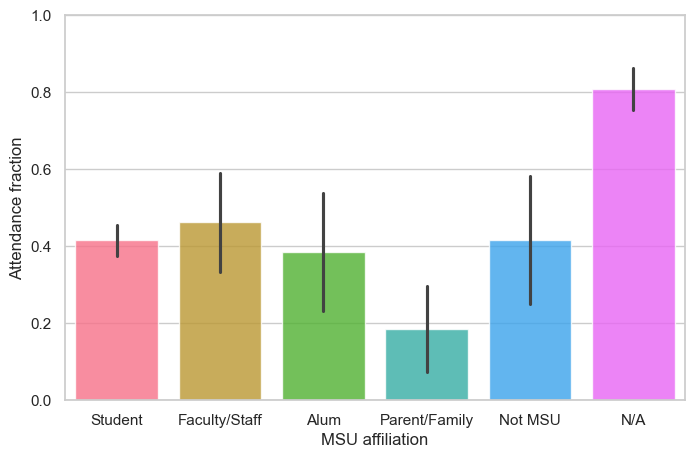

In [79]:
fig, ax = plt.subplots(figsize=(8,5))
fig = sns.barplot(data=reg_by_name, x='MSU affiliation', y='Percentage', palette='husl', 
                  hue='MSU affiliation', saturation=1, alpha=0.8, errorbar=('ci', 90))
ax.set(xlabel="MSU affiliation", ylabel="Attendance fraction", ylim=(0,1.0))
ax.get_legend().remove()
fig.figure.savefig("percent_affil_bar.png", bbox_inches='tight')
plt.show()

## TODO: assigning host name isn't working with the new pandas loc stuff, so none of this stuff is working.

## Hosts
Categorize and sort the attendance by people who 'hosted' (pre-registered others as their guest), and assign it to a new dataframe `hosts`.

In [45]:
hosts = pd.DataFrame(columns=('Name', 'Attended', 'Preregistered', 'Percentage', 'MSU affiliation'))
hosts['Name'] = registrants['Host name'][registrants['Host name'].notnull()].unique()
for i in range(len(hosts)):
    h = registrants['Visitor name'] == hosts['Name'][i]
    t1 = registrants['MSU affiliation'][h & registrants['MSU affiliation'][h].notnull()].unique()
    if len(t1) > 1 and "N/A" in t1:
        hosts['MSU affiliation'][i] = np.delete(t1, np.where(t1 == 'N/A'))[0]
    elif len(t1) == 1:
        hosts['MSU affiliation'][i] = t1[0]
    else:
        hosts['MSU affiliation'][i] = np.nan
    t2 = registrants['Attended'][h]
    hosts['Attended'][i] = sum(registrants['Attended'][h])
    hosts['Preregistered'][i] = sum(h)
hosts['Percentage'] = hosts['Attended'] / hosts['Preregistered']
print("Number of unique people who pre-registered guests: %d" % len(hosts))

Number of unique people who pre-registered guests: 361


In [46]:
print("\tSUM OF PRE-REGISTRATIONS:")
display(hosts.groupby('MSU affiliation', observed=False)['Preregistered'].sum())

	SUM OF PRE-REGISTRATIONS:


MSU affiliation
Alum             112
Faculty/Staff    117
N/A               55
Not MSU          117
Parent/Family     30
Student           65
Name: Preregistered, dtype: object

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(


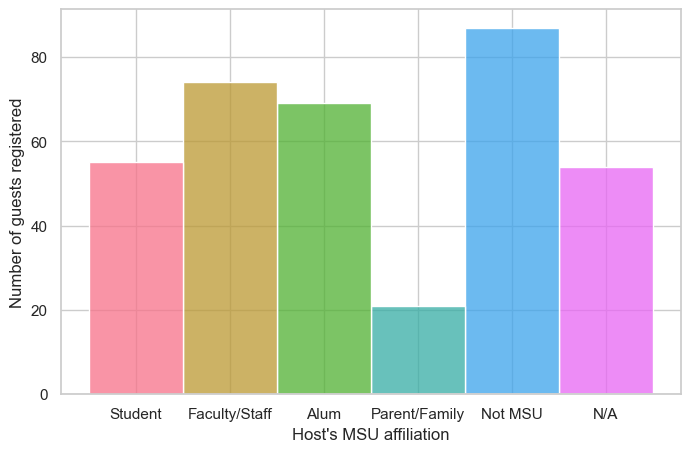

In [47]:
sns.set_palette("husl")
# sns.set_style("ticks")
hosts['MSU affiliation'] = pd.Categorical(hosts['MSU affiliation'], categories=affil_cats, ordered=True)
fig, ax = plt.subplots(figsize=(8,5))
fig = sns.histplot(data=hosts.sort_values('MSU affiliation'), x='MSU affiliation', hue='MSU affiliation', legend=False, alpha=0.75)
ax.set(xlabel="Host's MSU affiliation", ylabel="Number of guests registered")
fig.figure.savefig("pre-reg_guests_affil_bar.png", bbox_inches='tight')
plt.show()

In [48]:
print("\tMEAN GUEST ATTENDANCE PERCENTAGE by MSU HOST AFFILIATION:")
display(hosts.groupby('MSU affiliation', observed=False)['Percentage'].mean())
print("\tSUM OF ATTENDANCES:")
display(hosts.groupby('MSU affiliation', observed=False)['Attended'].sum())

	MEAN GUEST ATTENDANCE PERCENTAGE by MSU HOST AFFILIATION:


MSU affiliation
Student          0.523636
Faculty/Staff    0.530405
Alum             0.483981
Parent/Family    0.188095
Not MSU          0.333943
N/A              0.481481
Name: Percentage, dtype: object

	SUM OF ATTENDANCES:


MSU affiliation
Student          36
Faculty/Staff    60
Alum             60
Parent/Family     6
Not MSU          40
N/A              26
Name: Attended, dtype: object

/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


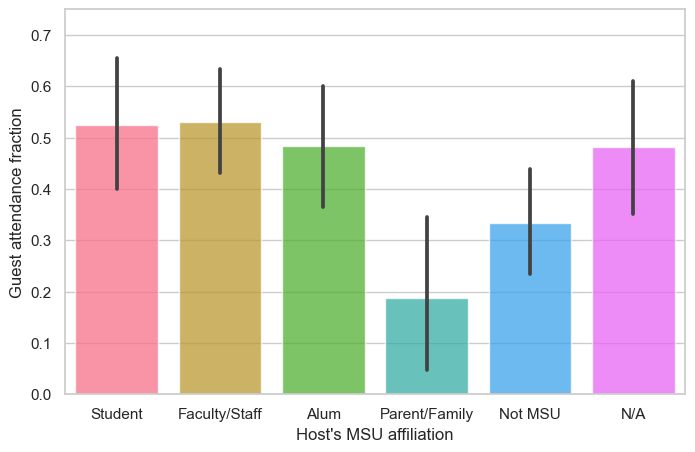

In [49]:
sns.set_palette("husl")
fig, ax = plt.subplots(figsize=(8,5))
fig = sns.barplot(data=hosts.sort_values('MSU affiliation'), x='MSU affiliation', y='Percentage', saturation=1, alpha=0.75)
ax.set(xlabel="Host's MSU affiliation", ylabel="Guest attendance fraction", ylim=(0, 0.75))
fig.figure.savefig("attend_guest_affil_bar.png", bbox_inches='tight')
plt.show()